In [1]:
import numpy as np
import matplotlib.pyplot as plt

from joblib import Parallel, delayed, parallel_backend
from psiam_tied_dv_map_utils_for_noise import psiam_tied_data_gen_wrapper_noise_change_no_L_T0_change
from psiam_tied_dv_map_utils_with_PDFs import all_RTs_fit_OPTIM_V_A_change_added_noise_fn, up_RTs_fit_OPTIM_V_A_change_added_noise_fn, down_RTs_fit_OPTIM_V_A_change_added_noise_fn
import pandas as pd
import random
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from scipy.integrate import trapezoid



# Params

In [2]:
V_A = 1.6
theta_A = 2.53

rate_lambda = 0.118
T_0 = 1/2220
theta_E = 45

t_A_aff = -0.187
t_E_aff = 0.075

Z_E = 0

N_sim = int(50e3)
dt = 1e-4

# ABL, ILD, stim and led times from data

In [3]:
# repeat_trial, T16, S7
og_df = pd.read_csv('../out_LED.csv')
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]


# t_stim, t_LED, ABL, ILD
t_stim_and_led_tuple = [(row['intended_fix'], row['intended_fix'] - row['LED_onset_time']) for _, row in df.iterrows()]
ABL_arr = df['ABL'].unique(); ABL_arr.sort()
ILD_arr = df['ILD'].unique(); ILD_arr.sort()


# 1 is right , -1 is left
df['choice'] = df['response_poke'].apply(lambda x: 1 if x == 3 else (-1 if x == 2 else random.choice([1, -1])))
# 1 or 0 if the choice was correct or not
df['correct'] = (df['ILD'] * df['choice']).apply(lambda x: 1 if x > 0 else 0)


#### LED OFF #####
df_led_off = df[df['LED_trial'] == 0]


### LED ON ###
df_led_on = df[df['LED_trial'] == 1]
df_led_on = df_led_on[df_led_on['LED_powerL'] == df_led_on['LED_powerR']]  # Bilateral, Left and right same power = 100

# simulate

In [4]:
np.random.seed(42)
sampled_indices = np.random.choice(len(t_stim_and_led_tuple), N_sim)
t_stim_and_led_tuple = [t_stim_and_led_tuple[i] for i in sampled_indices]

is_LED_trial = True

new_V_A = V_A + 1.8
new_noise = 80
T0_factor = 2.1
N_print = int(N_sim/5)

# Increase T0 -> dec  mu and sigma, add noise
sim_results = Parallel(n_jobs=30)(delayed(psiam_tied_data_gen_wrapper_noise_change_no_L_T0_change)(V_A, theta_A, ABL_arr, ILD_arr, rate_lambda, T_0, theta_E, Z_E, t_A_aff, t_E_aff,\
                                                                                    t_stim_and_led_tuple[iter_num], new_V_A, new_noise, T0_factor, iter_num, N_print, is_LED_trial, dt) for iter_num in range(N_sim))


sim_results_df = pd.DataFrame(sim_results)
sim_results_df['correct'] = (sim_results_df['ILD'] * sim_results_df['choice']).apply(lambda x: 1 if x > 0 else 0)

os id: 1822780, In iter_num: 0, ABL: 40, ILD: -1.0, t_stim: 0.479616722682289
os id: 1822834, In iter_num: 10000, ABL: 20, ILD: 8.0, t_stim: 0.261591017183307
os id: 1822787, In iter_num: 20000, ABL: 40, ILD: -8.0, t_stim: 0.777913584573004
os id: 1822779, In iter_num: 30000, ABL: 60, ILD: -1.0, t_stim: 1.28147530072172
os id: 1822832, In iter_num: 40000, ABL: 60, ILD: -16.0, t_stim: 0.202277061744796


In [5]:
print(f'T0 = {T_0*1e3: .3f} / ms, new T0 = {T_0 * T0_factor * 1e3 : .3f} / ms')

T0 =  0.450 / ms, new T0 =  0.946 / ms


# with aborts and without aborts

In [6]:
### data ###
# aborts > 0.3 OR success
data_df_led_on_with_aborts_0 = df_led_on[ ((df_led_on['abort_event'] == 3) & (df_led_on['timed_fix'] > 0.3)) \
                                          | (df_led_on['success'].isin([1,-1]))  ]

# TODO:  TEMP: we want to check with df_led_off
# data_df_led_on_with_aborts_0 = df_led_off[ ((df_led_off['abort_event'] == 3) & (df_led_off['timed_fix'] > 0.3)) \
#                                           | (df_led_off['success'].isin([1,-1]))  ]

# TODO: TEMP JUAN check 
# data_df_led_on_with_aborts_0 = df_led_on[ ~((df_led_on['abort_event'] == 3) & (df_led_on['timed_fix'] < 0.3)) ]

# NO RT - t_stim > 1
data_df_led_on_with_aborts = data_df_led_on_with_aborts_0[ \
    data_df_led_on_with_aborts_0['timed_fix'] - data_df_led_on_with_aborts_0['intended_fix'] < 1] 

data_df_led_on_with_aborts = data_df_led_on_with_aborts.rename(
                                        columns={'intended_fix': 't_stim', 'timed_fix': 'rt'}
                                    )

data_df_led_on_valid = data_df_led_on_with_aborts[data_df_led_on_with_aborts['success'].isin([1,-1])]


### sim ###
# remove left outliers: aborts < 0.3
sim_results_df_with_aborts_0 = sim_results_df[~((sim_results_df['rt'] < sim_results_df['t_stim']) & (sim_results_df['rt'] < 0.3))  ]
# remove right outliers: timed - fix > 1
sim_results_df_with_aborts = sim_results_df_with_aborts_0[sim_results_df_with_aborts_0['rt'] - sim_results_df_with_aborts_0['t_stim'] < 1]
# valid trials
sim_results_df_valid = sim_results_df_with_aborts[sim_results_df_with_aborts['rt'] > sim_results_df_with_aborts['t_stim']]

Text(0, 0.5, 'density')

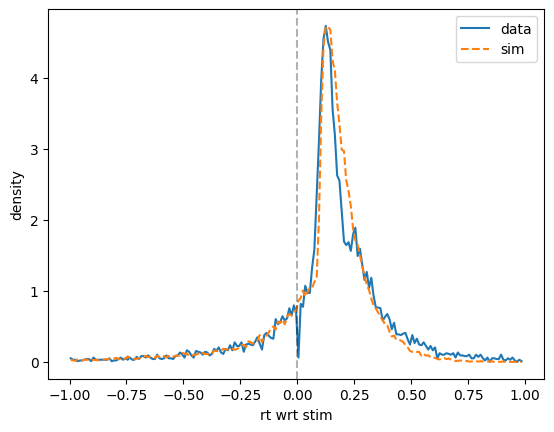

In [7]:
bins = np.arange(-1,1,0.01)
bin_centers = (bins[1:] + bins[:-1])/2

data_hist, _ = np.histogram(data_df_led_on_with_aborts['rt'] - data_df_led_on_with_aborts['t_stim'], bins=bins, density=True)
sim_hist, _ = np.histogram(sim_results_df_with_aborts['rt'] - sim_results_df_with_aborts['t_stim'], bins=bins, density=True)


plt.plot(bin_centers, data_hist, label='data')
plt.plot(bin_centers, sim_hist, label='sim', ls='--')
plt.axvline(0, color='k', ls='--', alpha=0.3)
plt.legend()
plt.xlabel('rt wrt stim')
plt.ylabel('density')

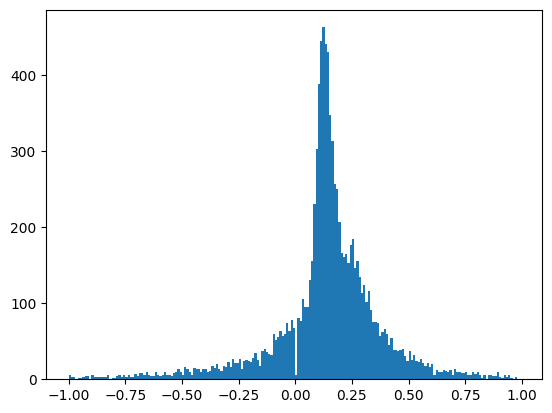

In [8]:
plt.hist(data_df_led_on_with_aborts['rt'] - data_df_led_on_with_aborts['t_stim'], bins=bins);

# diagnostics

In [9]:
from diagnostics_class import Diagnostics

sim_diag_with_aborts = Diagnostics(sim_results_df_with_aborts)
data_diag_with_aborts = Diagnostics(data_df_led_on_with_aborts)

sim_diag_valid = Diagnostics(sim_results_df_valid)
data_diag_valid = Diagnostics(data_df_led_on_valid)

# design diagnostics v3

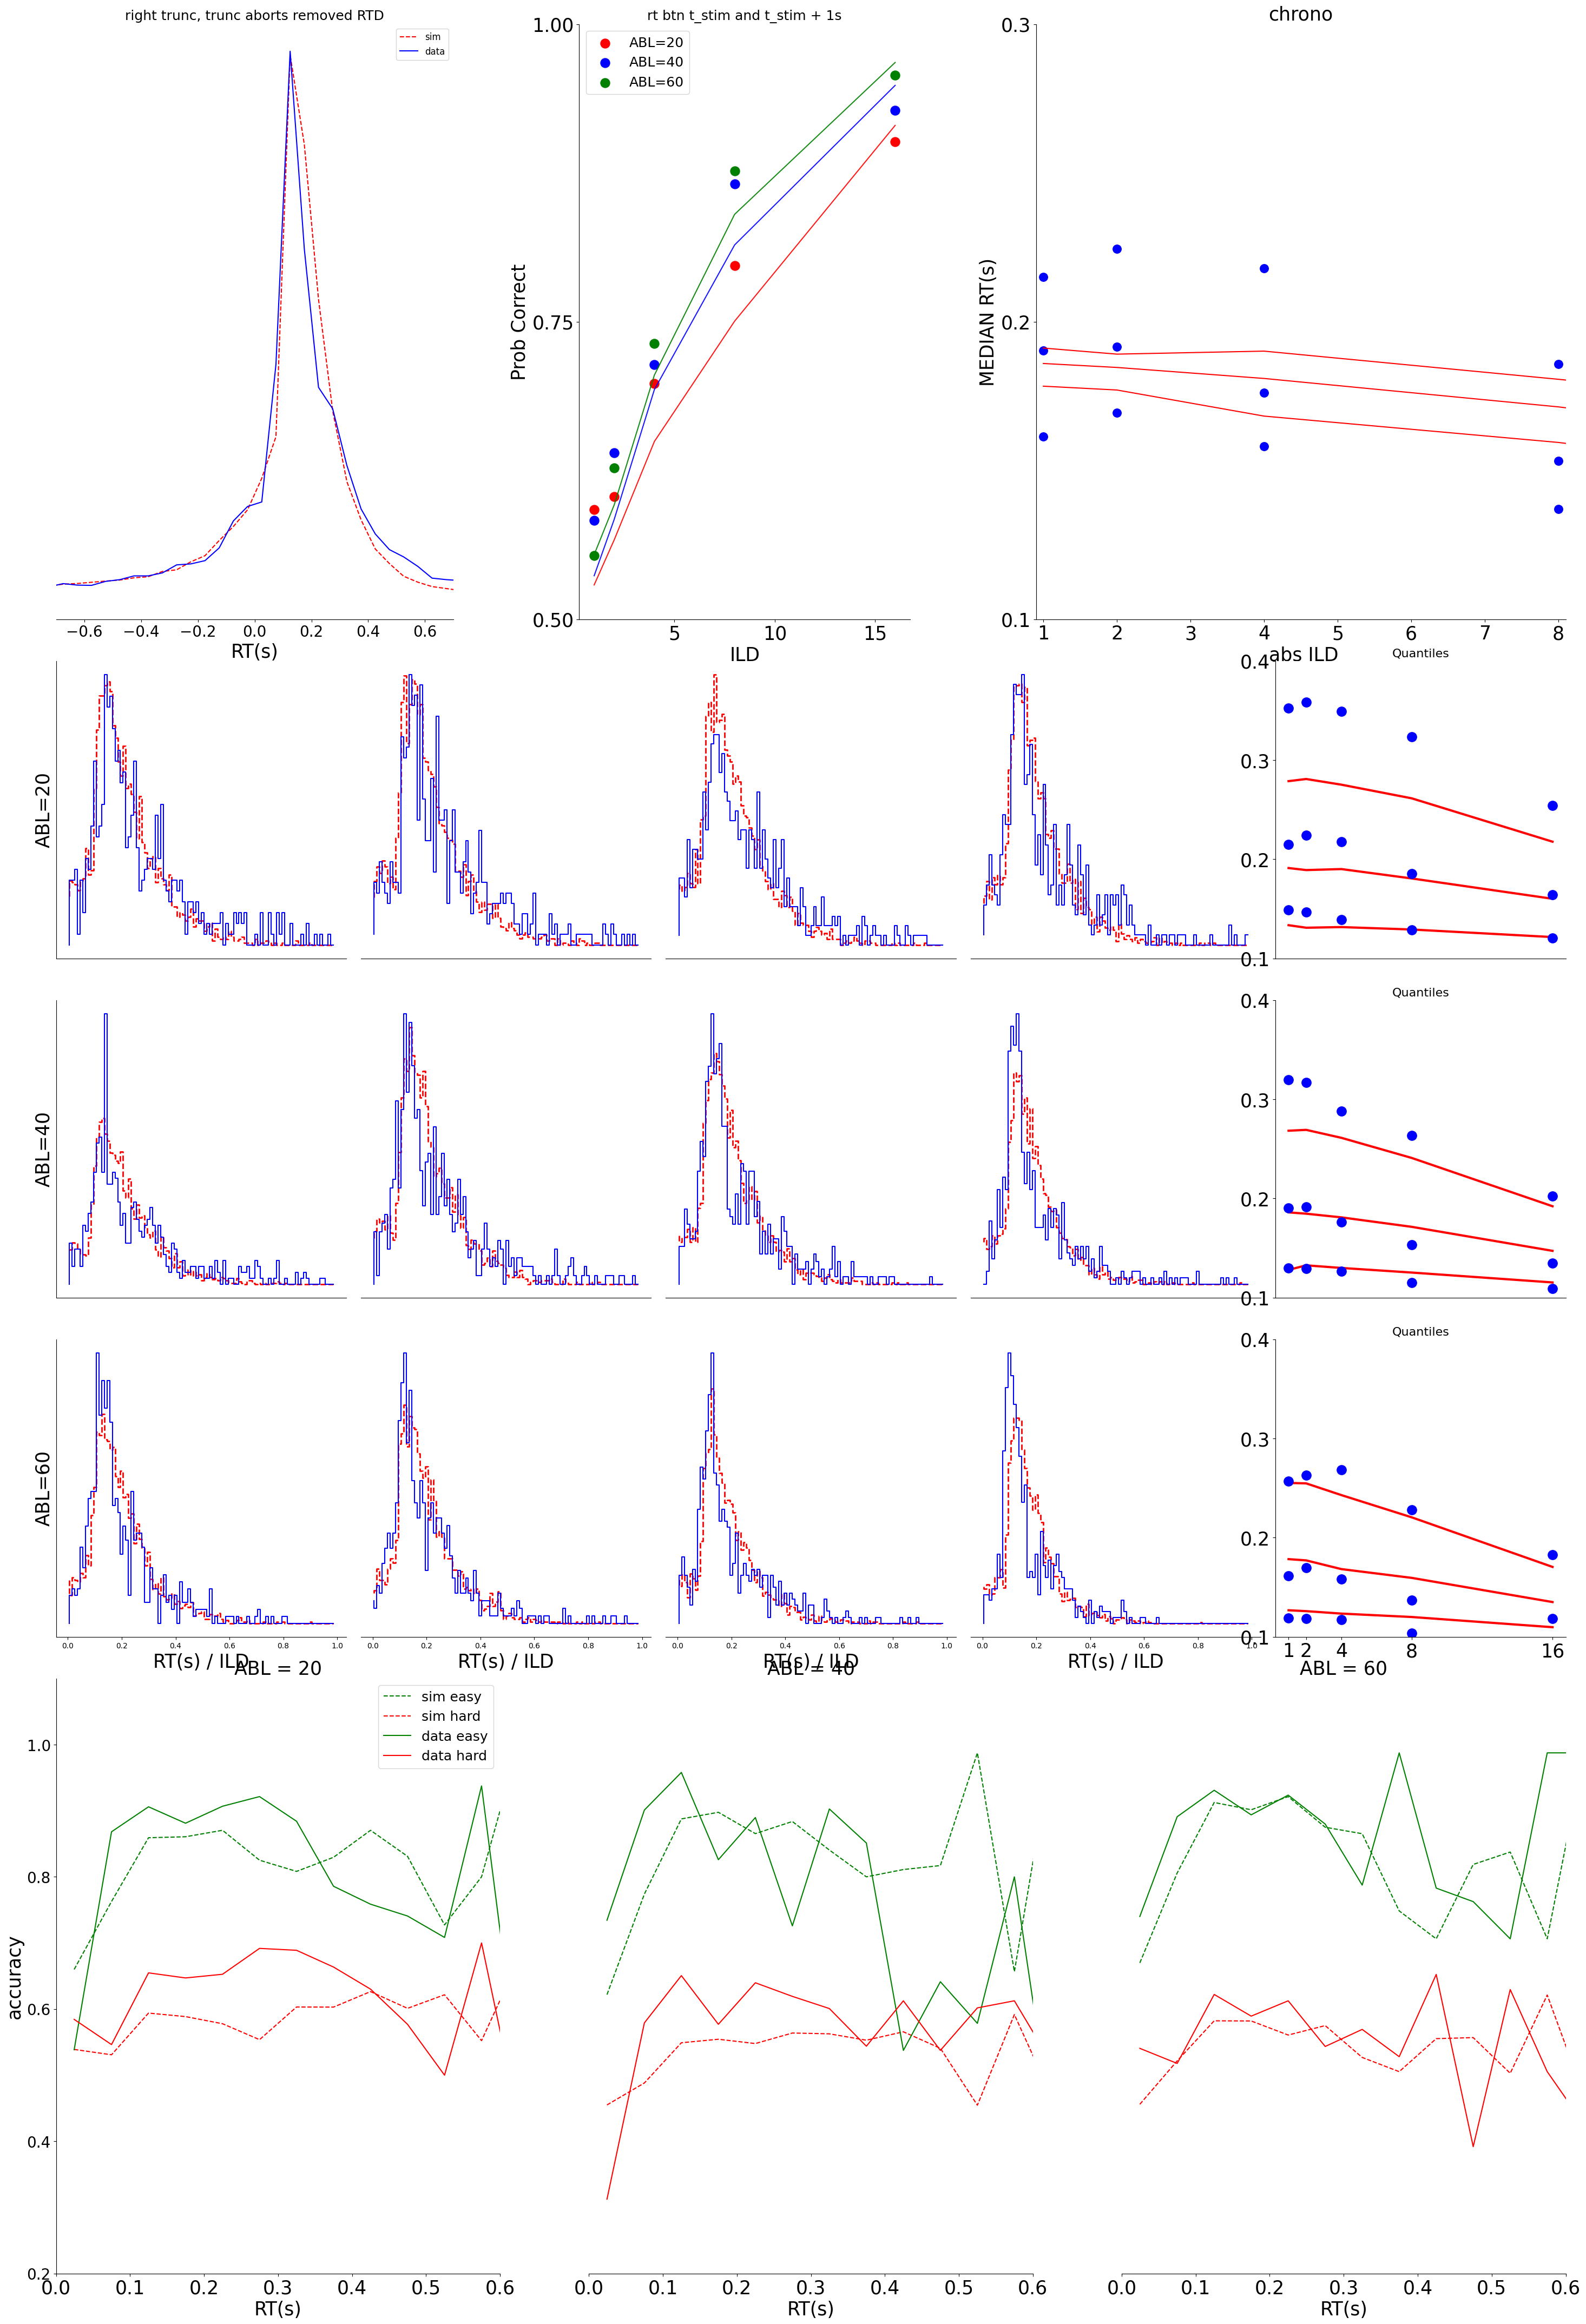

In [10]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

fig = plt.figure(figsize=(12*3, 18*3))
gs = GridSpec(nrows=5, ncols=5, figure=fig, hspace=0.1, wspace=0.05, height_ratios=[1, 0.5, 0.5, 0.5, 1])


# Create a sub‐GridSpec for row=0, spanning all columns
top_gs = gs[0, :]  # entire top row
top_subgs = GridSpecFromSubplotSpec(
    1, 3,                      # 1 row × 3 columns
    subplot_spec=top_gs,       # link to the main row=0
    width_ratios=[1.2, 1, 1.6],
    wspace=0.3              # horizontal spacing
)

# Make three subplots from top_subgs
ax_rtd     = fig.add_subplot(top_subgs[0, 0])
ax_psy     = fig.add_subplot(top_subgs[0, 1])
ax_chrono  = fig.add_subplot(top_subgs[0, 2])



ABL_colors = {20: 'r', 40: 'b', 60: 'g'}
ILD_colors = {1: 'r', 2: 'b', 4: 'g', 8: 'm', 16: 'k'}

### Grand RTD ###
bins = np.arange(-1, 1, 0.05)
x, y = sim_diag_with_aborts.plot_rtd_wrt_stim(bins)
ax_rtd.plot(x, y, label='sim', ls='--', color='r')

x, y = data_diag_with_aborts.plot_rtd_wrt_stim(bins)
ax_rtd.plot(x, y, label='data', color='b')

ax_rtd.set_title('right trunc, trunc aborts removed RTD', fontsize=18)
ax_rtd.set_xlabel('RT(s)', fontsize=25)
ax_rtd.tick_params(axis='both', which='major', labelsize=20)
ax_rtd.legend(fontsize=12)
ax_rtd.spines['top'].set_visible(False)
ax_rtd.spines['right'].set_visible(False)
ax_rtd.spines['left'].set_visible(False)
ax_rtd.set_yticks([])
ax_rtd.spines['bottom'].set_visible(True)
ax_rtd.set_xlim(-0.7, 0.7)
### END of Grand RTD ###

### Accuracy vs abs ILD ###
data_psycho = data_diag_valid.plot_correct_vs_abs_ILD()
all_ABL = data_psycho.keys()
all_ILD = np.sort(df['ILD'].unique())
all_pos_ILD = list(set(np.abs(df['ILD'].unique())))

sim_psycho = sim_diag_valid.plot_correct_vs_abs_ILD()
for ABL in all_ABL:
    ax_psy.scatter(all_pos_ILD, data_psycho[ABL], label=f'ABL={ABL}', color=ABL_colors[ABL], s=150)
    ax_psy.plot(all_pos_ILD, sim_psycho[ABL], alpha=0.9, color=ABL_colors[ABL])

ax_psy.set_xlabel('ILD', fontsize=25)
ax_psy.set_ylabel('Prob Correct', fontsize=25)
ax_psy.set_title('rt btn t_stim and t_stim + 1s', fontsize=18)
ax_psy.legend(fontsize=18)
ax_psy.spines['top'].set_visible(False)
ax_psy.spines['right'].set_visible(False)
ax_psy.spines['left'].set_visible(True)
ax_psy.spines['bottom'].set_visible(True)
ax_psy.tick_params(axis='x', which='major', labelsize=25)
ax_psy.tick_params(axis='y', which='major', labelsize=25)
ax_psy.set_yticks([0.5,0.75, 1.0])
### END of Accuracy vs abs ILD ###



### Chrono ###
x, sim_chrono = sim_diag_valid.plot_chrono_median()
for ABL in sim_chrono.keys():
    ax_chrono.plot(x, sim_chrono[ABL], color='r')

x, data_chrono = data_diag_valid.plot_chrono_median()
for ABL in data_chrono.keys():
    ax_chrono.scatter(x, data_chrono[ABL], label=f'data ABL={ABL}', color='b', marker='.', s=500)
# ax_chrono.legend(fontsize=18) # psycho covers it
ax_chrono.set_xlabel(' abs ILD', fontsize=25)
ax_chrono.set_ylabel('MEDIAN RT(s)', fontsize=25)
ax_chrono.set_title('chrono', fontsize=25)
ax_chrono.spines['top'].set_visible(False)
ax_chrono.spines['right'].set_visible(False)
ax_chrono.spines['left'].set_visible(True)
ax_chrono.spines['bottom'].set_visible(True)
ax_chrono.tick_params(axis='both', which='both', labelsize=25)
ax_chrono.set_xlim(0.9, 8.1)
ax_chrono.set_yticks(np.arange(0.1, 0.4, 0.1))
ax_chrono.set_ylim(0.1, 0.3)

### END of Chrono ###

### RTDs per ABL ###
# Get all positive ILDs (do not exclude the last one)
# Precompute quantile dictionaries using the provided function
sim_quantiles = sim_diag_valid.plot_quantile()  # {ABL: {ILD: [q10, q30, q50, q70, q90]}}
data_quantiles = data_diag_valid.plot_quantile()

# Get all positive ILDs (do not drop the last one)
bins = np.arange(0, 1, 0.01)

for a, ABL in enumerate(ABL_arr):
    row = a + 1
    for j, ILD in enumerate(all_pos_ILD):
        ax = fig.add_subplot(gs[row, j])
        
        # For all but the last column, plot the histograms for that abs ILD
        if j < len(all_pos_ILD) - 1:
            # Filter for current ABL and ILD (both signs)
            sim_pd = sim_results_df_valid[(sim_results_df_valid['ABL'] == ABL) & (sim_results_df_valid['ILD'].isin([ILD, -ILD]))]
            sim_rt = sim_pd['rt'] - sim_pd['t_stim']
            
            data_pd = data_df_led_on_valid[(data_df_led_on_valid['ABL'] == ABL) & (data_df_led_on_valid['ILD'].isin([ILD, -ILD]))]
            data_rt = data_pd['rt'] - data_pd['t_stim']
            
            sim_rt_hist, _ = np.histogram(sim_rt, density=True, bins=bins)
            data_rt_hist, _ = np.histogram(data_rt, density=True, bins=bins)
            t_pts = bins[:-1] + 0.5*(bins[1] - bins[0])
            
            ax.step(t_pts, sim_rt_hist, linestyle='dashed', color='r', label='sim', linewidth=2)
            ax.step(t_pts, data_rt_hist, label=f'data ILD={ILD}', color='b')
        
            if a == len(ABL_arr) - 1:
                ax.set_xlabel('RT(s) / ILD', fontsize=25)
            if j == 0:
                ax.set_ylabel(f'ABL={ABL}', fontsize=25)
                ax.tick_params(axis='y', which='major', labelsize=20)

            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(True)
            if j != 0:
                ax.spines['left'].set_visible(False)

            ax.set_yticks([])
        else:
            sim_qs = [sim_quantiles[ABL][ild] for ild in all_pos_ILD]
            data_qs = [data_quantiles[ABL][ild] for ild in all_pos_ILD]

            sim_qs = np.array(sim_qs)
            data_qs = np.array(data_qs)

            ax.plot(all_pos_ILD, sim_qs, lw=3,color='r')
            ax.plot(all_pos_ILD, data_qs, linestyle='', marker='.', markersize=25, color='b')
            ax.set_title('Quantiles', fontsize=16)

            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(True)
        
            # increase font size of x-axis labels
            ax.tick_params(axis='x', which='major', labelsize=25)
            ax.tick_params(axis='y', which='major', labelsize=25)
            ax.set_ylim(0.1, 0.4)
            ax.set_yticks(np.arange(0.1, 0.5, 0.1))
            ax.set_xticks(all_pos_ILD)
        # Format spines
        
        
        # Hide x-ticks for non-bottom rows
        if a < len(ABL_arr) - 1:
            ax.set_xticks([])


## END OF RTDs per ABL ### 

### Tachos per ABL ###
# --- Bottom row (row=4) => sub‐GridSpec 1×3 ---
bottom_gs = GridSpecFromSubplotSpec(
    1, 3, 
    subplot_spec=gs[4, 0:5],  # entire last row, columns 0..4
    wspace=0.2,
)

# “Blank” top sub‐row
ax_spacer = fig.add_subplot(bottom_gs[0, :])
ax_spacer.axis("off") 

ax_tacho_20 = fig.add_subplot(bottom_gs[0, 0])
ax_tacho_40 = fig.add_subplot(bottom_gs[0, 1])
ax_tacho_60 = fig.add_subplot(bottom_gs[0, 2])

ax_list  = [ax_tacho_20, ax_tacho_40, ax_tacho_60]

hard_ILD = np.array([1, 2, 4, -1, -2, -4]); easy_ILD = np.array([8, 16, -8, -16])
bins = np.arange(0, 1, 0.05)
for a, ABL in enumerate(ABL_arr):
    ax_r = ax_list[a]

    # sim - easy
    sim_pd_easy = sim_results_df_valid[(sim_results_df_valid['ABL'] == ABL) & (sim_results_df_valid['ILD'].isin(easy_ILD))]
    sim_pd_easy_diag = Diagnostics(sim_pd_easy)
    x, sim_easy_tacho = sim_pd_easy_diag.plot_tacho(bins)
    ax_r.plot(x, sim_easy_tacho, linestyle='dashed', label='sim easy', color='g')
    
    # sim - hard
    sim_pd_hard = sim_results_df_valid[(sim_results_df_valid['ABL'] == ABL) & (sim_results_df_valid['ILD'].isin(hard_ILD))]
    sim_pd_hard_diag = Diagnostics(sim_pd_hard)
    x, sim_hard_tacho = sim_pd_hard_diag.plot_tacho(bins)
    ax_r.plot(x, sim_hard_tacho, label='sim hard', color='r', linestyle='dashed')

    # data - easy
    data_pd_easy = data_df_led_on_valid[ (data_df_led_on_valid['ABL'] == ABL) & (data_df_led_on_valid['ILD'].isin(easy_ILD))]
    data_pd_easy_diag = Diagnostics(data_pd_easy)
    x, data_easy_tacho = data_pd_easy_diag.plot_tacho(bins)
    ax_r.plot(x, data_easy_tacho, label='data easy', color='g')

    # data - hard
    data_pd_hard = data_df_led_on_valid[ (data_df_led_on_valid['ABL'] == ABL) & (data_df_led_on_valid['ILD'].isin(hard_ILD))]
    data_pd_hard_diag = Diagnostics(data_pd_hard)
    x, data_hard_tacho = data_pd_hard_diag.plot_tacho(bins)
    ax_r.plot(x, data_hard_tacho, label='data hard', color='r')

    ax_r.set_title(f'ABL = {ABL}', fontsize=25)
    ax_r.set_xlabel('RT(s)', fontsize=25)
    if a == 0:
        ax_r.legend(fontsize=18)
        ax_r.set_ylabel('accuracy', fontsize=25)

    ax_r.set_xlim(0, 0.6)
    ax_r.set_ylim(0.3, 1.1)
    ax_r.spines['top'].set_visible(False)
    ax_r.spines['right'].set_visible(False)
    ax_r.spines['left'].set_visible(True)
    ax_r.spines['bottom'].set_visible(True)
    if a == 0:
        ax_r.set_yticks(np.arange(0.2, 1.2, 0.2))

    if a != 0:
        ax_r.spines['left'].set_visible(False)
        ax_r.set_yticks([])
    
    ax_r.tick_params(axis='both', which='major', labelsize=20)
    ax_r.tick_params(axis='x', which='major', labelsize=25)




# design diagnosis v4

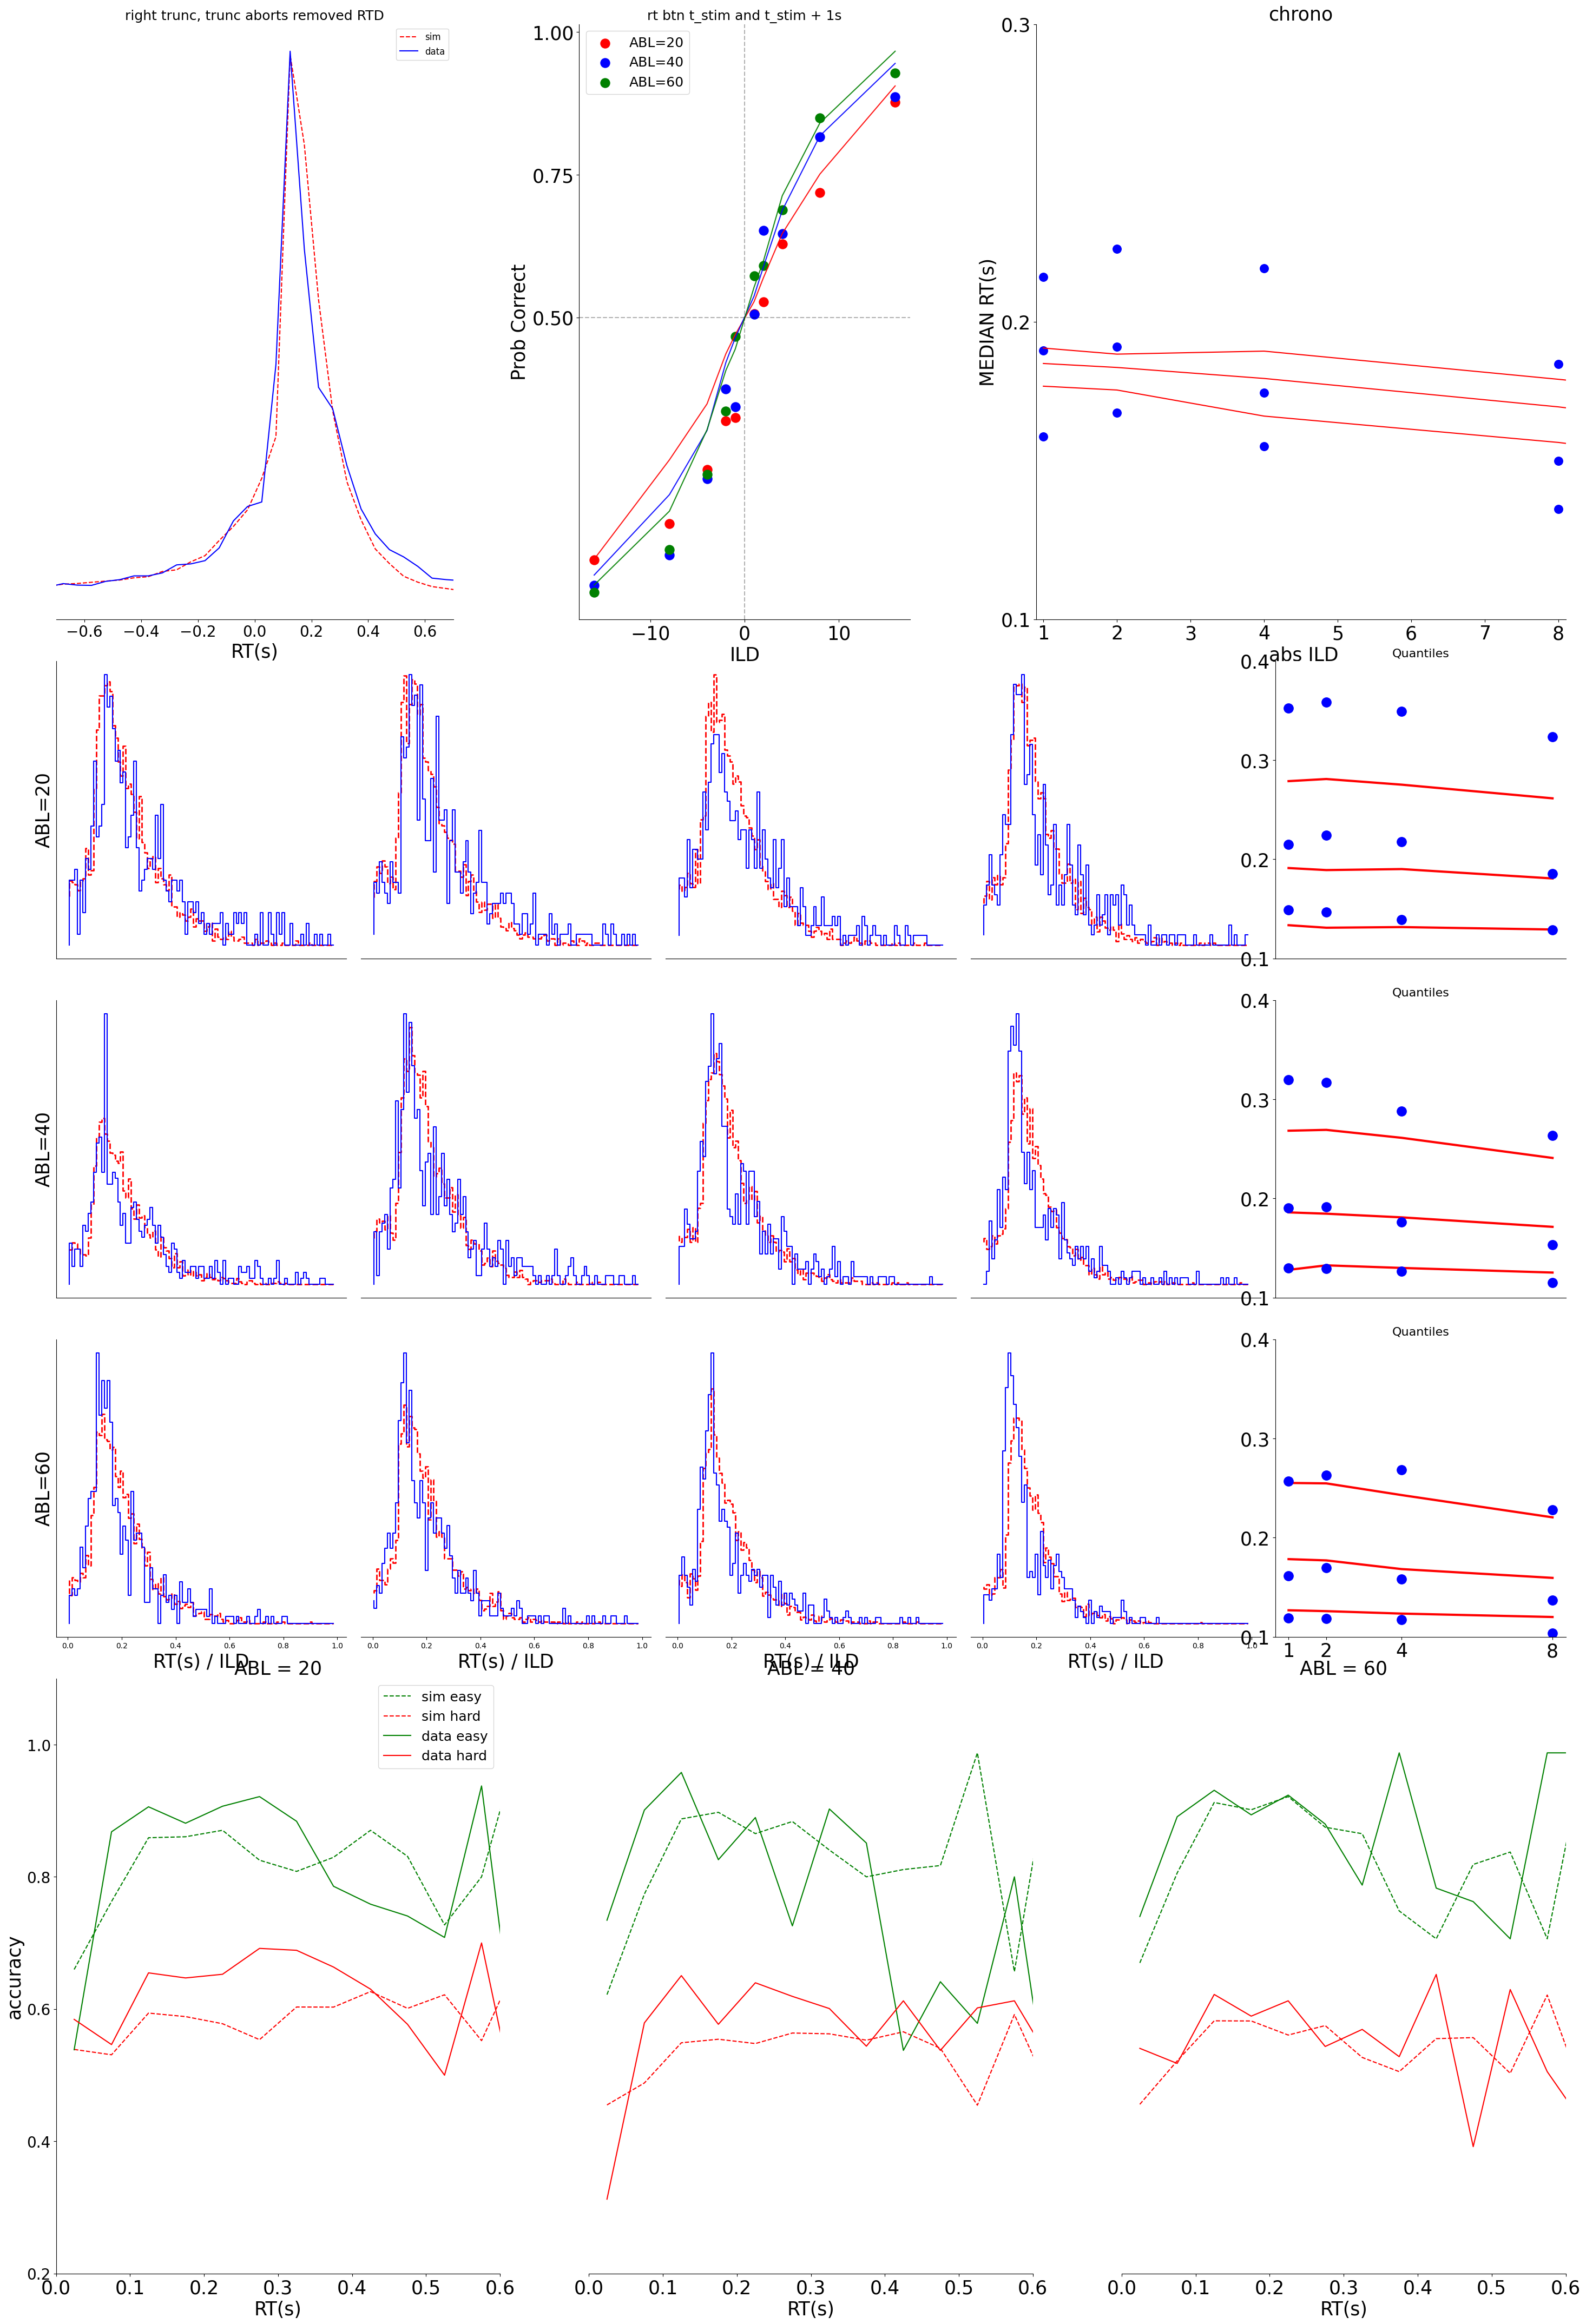

In [11]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

fig = plt.figure(figsize=(12*3, 18*3))
gs = GridSpec(nrows=5, ncols=5, figure=fig, hspace=0.1, wspace=0.05, height_ratios=[1, 0.5, 0.5, 0.5, 1])


# Create a sub‐GridSpec for row=0, spanning all columns
top_gs = gs[0, :]  # entire top row
top_subgs = GridSpecFromSubplotSpec(
    1, 3,                      # 1 row × 3 columns
    subplot_spec=top_gs,       # link to the main row=0
    width_ratios=[1.2, 1, 1.6],
    wspace=0.3              # horizontal spacing
)

# Make three subplots from top_subgs
ax_rtd     = fig.add_subplot(top_subgs[0, 0])
ax_psy     = fig.add_subplot(top_subgs[0, 1])
ax_chrono  = fig.add_subplot(top_subgs[0, 2])



ABL_colors = {20: 'r', 40: 'b', 60: 'g'}
ILD_colors = {1: 'r', 2: 'b', 4: 'g', 8: 'm', 16: 'k'}

### Grand RTD ###
bins = np.arange(-1, 1, 0.05)
x, y = sim_diag_with_aborts.plot_rtd_wrt_stim(bins)
ax_rtd.plot(x, y, label='sim', ls='--', color='r')

x, y = data_diag_with_aborts.plot_rtd_wrt_stim(bins)
ax_rtd.plot(x, y, label='data', color='b')

ax_rtd.set_title('right trunc, trunc aborts removed RTD', fontsize=18)
ax_rtd.set_xlabel('RT(s)', fontsize=25)
ax_rtd.tick_params(axis='both', which='major', labelsize=20)
ax_rtd.legend(fontsize=12)
ax_rtd.spines['top'].set_visible(False)
ax_rtd.spines['right'].set_visible(False)
ax_rtd.spines['left'].set_visible(False)
ax_rtd.set_yticks([])
ax_rtd.spines['bottom'].set_visible(True)
ax_rtd.set_xlim(-0.7, 0.7)
### END of Grand RTD ###

### Accuracy vs abs ILD ###
data_psycho = data_diag_valid.plot_psycho()
all_ABL = data_psycho.keys()
all_ILD = np.sort(df['ILD'].unique())
all_pos_ILD = list(set(np.abs(df['ILD'].unique())))

sim_psycho = sim_diag_valid.plot_psycho()
for ABL in all_ABL:
    ax_psy.scatter(all_ILD, data_psycho[ABL], label=f'ABL={ABL}', color=ABL_colors[ABL], s=150)
    ax_psy.plot(all_ILD, sim_psycho[ABL], alpha=0.9, color=ABL_colors[ABL])

ax_psy.set_xlabel('ILD', fontsize=25)
ax_psy.set_ylabel('Prob Correct', fontsize=25)
ax_psy.set_title('rt btn t_stim and t_stim + 1s', fontsize=18)
ax_psy.legend(fontsize=18)
ax_psy.spines['top'].set_visible(False)
ax_psy.spines['right'].set_visible(False)
ax_psy.spines['left'].set_visible(True)
ax_psy.spines['bottom'].set_visible(True)
ax_psy.tick_params(axis='x', which='major', labelsize=25)
ax_psy.tick_params(axis='y', which='major', labelsize=25)
ax_psy.set_yticks([0.5,0.75, 1.0])
ax_psy.axvline(0, color='k', ls='--', alpha=0.3)
ax_psy.axhline(0.5, color='k', ls='--', alpha=0.3)

### END of Accuracy vs abs ILD ###



### Chrono ###
x, sim_chrono = sim_diag_valid.plot_chrono_median()
for ABL in sim_chrono.keys():
    ax_chrono.plot(x, sim_chrono[ABL], color='r')

x, data_chrono = data_diag_valid.plot_chrono_median()
for ABL in data_chrono.keys():
    ax_chrono.scatter(x, data_chrono[ABL], label=f'data ABL={ABL}', color='b', marker='.', s=500)
# ax_chrono.legend(fontsize=18) # psycho covers it
ax_chrono.set_xlabel(' abs ILD', fontsize=25)
ax_chrono.set_ylabel('MEDIAN RT(s)', fontsize=25)
ax_chrono.set_title('chrono', fontsize=25)
ax_chrono.spines['top'].set_visible(False)
ax_chrono.spines['right'].set_visible(False)
ax_chrono.spines['left'].set_visible(True)
ax_chrono.spines['bottom'].set_visible(True)
ax_chrono.tick_params(axis='both', which='both', labelsize=25)
ax_chrono.set_xlim(0.9, 8.1)
ax_chrono.set_yticks(np.arange(0.1, 0.4, 0.1))
ax_chrono.set_ylim(0.1, 0.3)

### END of Chrono ###

### RTDs per ABL ###
# Get all positive ILDs (do not exclude the last one)
# Precompute quantile dictionaries using the provided function
sim_quantiles = sim_diag_valid.plot_quantile()  # {ABL: {ILD: [q10, q30, q50, q70, q90]}}
data_quantiles = data_diag_valid.plot_quantile()

# Get all positive ILDs (do not drop the last one)
bins = np.arange(0, 1, 0.01)

for a, ABL in enumerate(ABL_arr):
    row = a + 1
    for j, ILD in enumerate(all_pos_ILD):
        ax = fig.add_subplot(gs[row, j])
        
        # For all but the last column, plot the histograms for that abs ILD
        if j < len(all_pos_ILD) - 1:
            # Filter for current ABL and ILD (both signs)
            sim_pd = sim_results_df_valid[(sim_results_df_valid['ABL'] == ABL) & (sim_results_df_valid['ILD'].isin([ILD, -ILD]))]
            sim_rt = sim_pd['rt'] - sim_pd['t_stim']
            
            data_pd = data_df_led_on_valid[(data_df_led_on_valid['ABL'] == ABL) & (data_df_led_on_valid['ILD'].isin([ILD, -ILD]))]
            data_rt = data_pd['rt'] - data_pd['t_stim']
            
            sim_rt_hist, _ = np.histogram(sim_rt, density=True, bins=bins)
            data_rt_hist, _ = np.histogram(data_rt, density=True, bins=bins)
            t_pts = bins[:-1] + 0.5*(bins[1] - bins[0])
            
            ax.step(t_pts, sim_rt_hist, linestyle='dashed', color='r', label='sim', linewidth=2)
            ax.step(t_pts, data_rt_hist, label=f'data ILD={ILD}', color='b')
        
            if a == len(ABL_arr) - 1:
                ax.set_xlabel('RT(s) / ILD', fontsize=25)
            if j == 0:
                ax.set_ylabel(f'ABL={ABL}', fontsize=25)
                ax.tick_params(axis='y', which='major', labelsize=20)

            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(True)
            if j != 0:
                ax.spines['left'].set_visible(False)

            ax.set_yticks([])
        else:
            sim_qs = [sim_quantiles[ABL][ild] for ild in all_pos_ILD]
            data_qs = [data_quantiles[ABL][ild] for ild in all_pos_ILD]

            sim_qs = np.array(sim_qs)
            data_qs = np.array(data_qs)

            ax.plot(all_pos_ILD[:-1], sim_qs[:-1,:], lw=3,color='r')
            ax.plot(all_pos_ILD[:-1], data_qs[:-1,:], linestyle='', marker='.', markersize=25, color='b')
            ax.set_title('Quantiles', fontsize=16)

            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(True)
        
            # increase font size of x-axis labels
            ax.tick_params(axis='x', which='major', labelsize=25)
            ax.tick_params(axis='y', which='major', labelsize=25)
            ax.set_ylim(0.1, 0.4)
            ax.set_yticks(np.arange(0.1, 0.5, 0.1))
            ax.set_xticks(all_pos_ILD[:-1])
        # Format spines
        
        
        # Hide x-ticks for non-bottom rows
        if a < len(ABL_arr) - 1:
            ax.set_xticks([])


## END OF RTDs per ABL ### 

### Tachos per ABL ###
# --- Bottom row (row=4) => sub‐GridSpec 1×3 ---
bottom_gs = GridSpecFromSubplotSpec(
    1, 3, 
    subplot_spec=gs[4, 0:5],  # entire last row, columns 0..4
    wspace=0.2,
)

# “Blank” top sub‐row
ax_spacer = fig.add_subplot(bottom_gs[0, :])
ax_spacer.axis("off") 

ax_tacho_20 = fig.add_subplot(bottom_gs[0, 0])
ax_tacho_40 = fig.add_subplot(bottom_gs[0, 1])
ax_tacho_60 = fig.add_subplot(bottom_gs[0, 2])

ax_list  = [ax_tacho_20, ax_tacho_40, ax_tacho_60]

hard_ILD = np.array([1, 2, 4, -1, -2, -4]); easy_ILD = np.array([8, 16, -8, -16])
bins = np.arange(0, 1, 0.05)
for a, ABL in enumerate(ABL_arr):
    ax_r = ax_list[a]

    # sim - easy
    sim_pd_easy = sim_results_df_valid[(sim_results_df_valid['ABL'] == ABL) & (sim_results_df_valid['ILD'].isin(easy_ILD))]
    sim_pd_easy_diag = Diagnostics(sim_pd_easy)
    x, sim_easy_tacho = sim_pd_easy_diag.plot_tacho(bins)
    ax_r.plot(x, sim_easy_tacho, linestyle='dashed', label='sim easy', color='g')
    
    # sim - hard
    sim_pd_hard = sim_results_df_valid[(sim_results_df_valid['ABL'] == ABL) & (sim_results_df_valid['ILD'].isin(hard_ILD))]
    sim_pd_hard_diag = Diagnostics(sim_pd_hard)
    x, sim_hard_tacho = sim_pd_hard_diag.plot_tacho(bins)
    ax_r.plot(x, sim_hard_tacho, label='sim hard', color='r', linestyle='dashed')

    # data - easy
    data_pd_easy = data_df_led_on_valid[ (data_df_led_on_valid['ABL'] == ABL) & (data_df_led_on_valid['ILD'].isin(easy_ILD))]
    data_pd_easy_diag = Diagnostics(data_pd_easy)
    x, data_easy_tacho = data_pd_easy_diag.plot_tacho(bins)
    ax_r.plot(x, data_easy_tacho, label='data easy', color='g')

    # data - hard
    data_pd_hard = data_df_led_on_valid[ (data_df_led_on_valid['ABL'] == ABL) & (data_df_led_on_valid['ILD'].isin(hard_ILD))]
    data_pd_hard_diag = Diagnostics(data_pd_hard)
    x, data_hard_tacho = data_pd_hard_diag.plot_tacho(bins)
    ax_r.plot(x, data_hard_tacho, label='data hard', color='r')

    ax_r.set_title(f'ABL = {ABL}', fontsize=25)
    ax_r.set_xlabel('RT(s)', fontsize=25)
    if a == 0:
        ax_r.legend(fontsize=18)
        ax_r.set_ylabel('accuracy', fontsize=25)

    ax_r.set_xlim(0, 0.6)
    ax_r.set_ylim(0.3, 1.1)
    ax_r.spines['top'].set_visible(False)
    ax_r.spines['right'].set_visible(False)
    ax_r.spines['left'].set_visible(True)
    ax_r.spines['bottom'].set_visible(True)
    if a == 0:
        ax_r.set_yticks(np.arange(0.2, 1.2, 0.2))

    if a != 0:
        ax_r.spines['left'].set_visible(False)
        ax_r.set_yticks([])
    
    ax_r.tick_params(axis='both', which='major', labelsize=20)
    ax_r.tick_params(axis='x', which='major', labelsize=25)




# theory up and down

In [12]:
t_pts = np.arange(-1, 1, 0.01)
N_theory = int(5e3)

ABL_samples = np.random.choice(ABL_arr, N_theory)
ILD_samples = np.random.choice(ILD_arr, N_theory)

t_stim_and_led_array = np.array(t_stim_and_led_tuple) 
sampled_indices = np.random.choice(len(t_stim_and_led_tuple), N_theory)  # Sample indices
t_stim_and_t_LED_samples = t_stim_and_led_array[sampled_indices] 


K_max = 10;  V_A_post_LED = new_V_A; noise = new_noise
def compute_rtd_up(idx):
    t_stim, t_LED = t_stim_and_t_LED_samples[idx]
    ABL = ABL_samples[idx]
    ILD = ILD_samples[idx]

    if t_LED > t_stim:
        print(f'ISSUE: t_LED > t_stim: {t_LED} > {t_stim}')

    pdf_single_sample = []
    for t_val in t_pts:
        val = up_RTs_fit_OPTIM_V_A_change_added_noise_fn(t_val + t_stim, t_LED, V_A, V_A_post_LED, theta_A, \
                                                         ABL, ILD, rate_lambda, T_0 * T0_factor, noise,\
                                                              theta_E, Z_E, t_stim, t_A_aff, t_E_aff, K_max)

        pdf_single_sample.append(val)

    

    
    return pdf_single_sample

results_up = Parallel(n_jobs=-1)(delayed(compute_rtd_up)(i) for i in tqdm(range(N_theory)))

all_RTD_vs_N_theory_P_up = np.array(results_up)


def compute_rtd_down(idx):
    t_stim, t_LED = t_stim_and_t_LED_samples[idx]
    ABL = ABL_samples[idx]
    ILD = ILD_samples[idx]

    if t_LED > t_stim:
        print(f'ISSUE: t_LED > t_stim: {t_LED} > {t_stim}')

    pdf_single_sample = []
    for t_val in t_pts:
        val = down_RTs_fit_OPTIM_V_A_change_added_noise_fn(t_val + t_stim, t_LED, V_A, V_A_post_LED, theta_A, \
                                                         ABL, ILD, rate_lambda, T_0 * T0_factor, noise,\
                                                              theta_E, Z_E, t_stim, t_A_aff, t_E_aff, K_max)

        pdf_single_sample.append(val)

    

    
    return pdf_single_sample

results_down = Parallel(n_jobs=-1)(delayed(compute_rtd_down)(i) for i in tqdm(range(N_theory)))

all_RTD_vs_N_theory_P_down = np.array(results_down)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

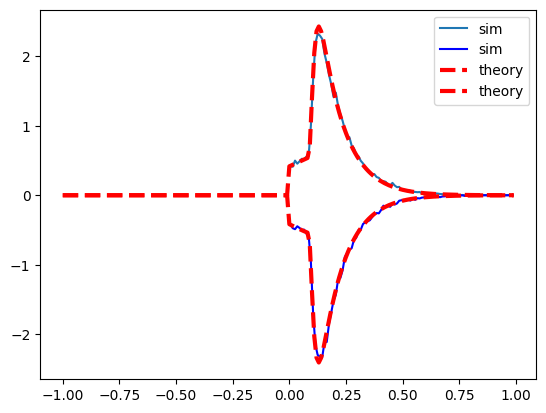

In [14]:
sim_up_rt = [res['rt'] - res['t_stim']  for res in sim_results if res['choice'] == 1 and res['rt'] > res['t_stim']]
sim_down_rt = [res['rt'] - res['t_stim']  for res in sim_results if res['choice'] == -1 and res['rt'] > res['t_stim']]

bins = np.arange(0,1,0.01)
bin_centers = (bins[1:] + bins[:-1])/2

sim_up_hist, _ = np.histogram(sim_up_rt, bins=bins, density=True)
frac_up_rt = len(sim_up_rt)/len(sim_results)

sim_down_hist, _ = np.histogram(sim_down_rt, bins=bins, density=True)
frac_down_rt = len(sim_down_rt)/len(sim_results)

plt.plot(bin_centers, sim_up_hist * frac_up_rt, label='sim')
plt.plot(bin_centers, -sim_down_hist * frac_down_rt, label='sim', color='b')

mean_all_RTD_vs_N_theory_P_up = np.mean(all_RTD_vs_N_theory_P_up, axis=0)
plt.plot(t_pts, mean_all_RTD_vs_N_theory_P_up, label='theory', ls='--', lw=3, color='r')

mean_all_RTD_vs_N_theory_P_down = np.mean(all_RTD_vs_N_theory_P_down, axis=0)
plt.plot(t_pts, -mean_all_RTD_vs_N_theory_P_down, label='theory', ls='--', lw=3, color='r')

plt.legend()

# theory wrt fix

In [ ]:
t_pts = np.arange(-2, 2, 0.01)
N_theory = int(1e3)

ABL_samples = np.random.choice(ABL_arr, N_theory)
ILD_samples = np.random.choice(ILD_arr, N_theory)


t_stim_and_led_array = np.array(t_stim_and_led_tuple) 
sampled_indices = np.random.choice(len(t_stim_and_led_tuple), N_theory)  # Sample indices
t_stim_and_t_LED_samples = t_stim_and_led_array[sampled_indices] 


K_max = 10;  V_A_post_LED = new_V_A; noise = new_noise
def compute_rtd(idx):
    t_stim, t_LED = t_stim_and_t_LED_samples[idx]
    ABL = ABL_samples[idx]
    ILD = ILD_samples[idx]

    if t_LED > t_stim:
        print(f'ISSUE: t_LED > t_stim: {t_LED} > {t_stim}')

    return [
        all_RTs_fit_OPTIM_V_A_change_added_noise_fn(
            t, t_LED, V_A, V_A_post_LED, theta_A, ABL, ILD,
            rate_lambda, T_0 * T0_factor, noise, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, K_max
        ) for t in t_pts
    ]

results = Parallel(n_jobs=-1)(delayed(compute_rtd)(i) for i in tqdm(range(N_theory)))

all_RTD_vs_N_theory_P = np.array(results)

In [ ]:
mean_all_RTD_vs_N_theory_P = np.mean(all_RTD_vs_N_theory_P, axis=0)
plt.plot(t_pts, mean_all_RTD_vs_N_theory_P, label='theory', ls='--', lw=3, color='r')

sim_results_df_diag = Diagnostics(sim_results_df)
bins = np.arange(-2,2, 0.1)
t_x , sim_RTD = sim_results_df_diag.plot_rtd_wrt_fix(bins)
plt.plot(t_x, sim_RTD, label='sim', color='b')

plt.title('sim RTD vs theory ')
plt.legend()

In [ ]:
sim_area = trapezoid(sim_RTD, t_x)
theory_area = trapezoid(mean_all_RTD_vs_N_theory_P, t_pts)

print(f'sim area = {sim_area}, theory area = {theory_area}')

# theory wrt stim

In [ ]:
t_pts = np.arange(-2, 2, 0.01)
N_theory = int(5e3)

ABL_samples = np.random.choice(ABL_arr, N_theory)
ILD_samples = np.random.choice(ILD_arr, N_theory)

t_stim_and_led_array = np.array(t_stim_and_led_tuple) 
sampled_indices = np.random.choice(len(t_stim_and_led_tuple), N_theory)  # Sample indices
t_stim_and_t_LED_samples = t_stim_and_led_array[sampled_indices] 


K_max = 10;  V_A_post_LED = new_V_A; noise = new_noise
def compute_rtd(idx):
    t_stim, t_LED = t_stim_and_t_LED_samples[idx]
    ABL = ABL_samples[idx]
    ILD = ILD_samples[idx]

    if t_LED > t_stim:
        print(f'ISSUE: t_LED > t_stim: {t_LED} > {t_stim}')

    pdf_single_sample = []
    for t_val in t_pts:
        val = all_RTs_fit_OPTIM_V_A_change_added_noise_fn(
            t_val + t_stim, t_LED,
            V_A, V_A_post_LED, theta_A,
            ABL, ILD,
            rate_lambda,
            T_0 * T0_factor,
            noise,
            theta_E, Z_E,
            t_stim, t_A_aff, t_E_aff,
            K_max
        )
        if val > 30:
            print(
                f"Large value {val:.2f} at t={t_val + t_stim} "
                f"for ABL={ABL}, ILD={ILD}, "
                f"t_stim={t_stim}, t_LED={t_LED}"
            )
        pdf_single_sample.append(val)

    

    
    return pdf_single_sample

results = Parallel(n_jobs=-1)(delayed(compute_rtd)(i) for i in tqdm(range(N_theory)))

all_RTD_vs_N_theory_P = np.array(results)

In [ ]:
mean_all_RTD_vs_N_theory_P = np.mean(all_RTD_vs_N_theory_P, axis=0)
plt.plot(t_pts, mean_all_RTD_vs_N_theory_P, label='theory', ls='--', lw=3, color='r')

sim_results_df_diag = Diagnostics(sim_results_df)
bins = np.arange(-2,2, 0.01)
t_x , sim_RTD = sim_results_df_diag.plot_rtd_wrt_stim(bins)
plt.plot(t_x, sim_RTD, label='sim', color='b')

plt.title('sim RTD vs theory ')
plt.legend()
plt.ylim(0, 7)

In [ ]:
print(f'area under sim = {trapezoid(sim_RTD, t_x)}, area under theory = {trapezoid(mean_all_RTD_vs_N_theory_P, t_pts)}')

# debug area

In [ ]:
# Large value 27650.75 at t=0.22024944827545656 for ABL=60, ILD=-2.0, t_stim=0.470249448275455, t_LED=0.220249448275455
t_stim = 0.470249448275455
t_LED =  0.220249448275455
t = 0.22024944827545656 - t_stim
ABL = 60
ILD = -2.0

from psiam_tied_dv_map_utils_with_PDFs import d_A_RT, stupid_f_integral

def PA_with_LEDON_2_debug(t, v, vON, a, tfix, tled, delta_A):
    """
    Compute the PA pdf by combining contributions before and after LED onset.

    Parameters:
        t (float): Time value.
        v (float): Drift parameter before LED.
        vON (float): Drift parameter after LED onset.
        a (float): Decision bound.
        tfix (float): Fixation time.
        tled (float): LED time.
        delta_A (float): Delta parameter.

    Returns:
        float: The combined PA pdf value.
    """
    # For a scalar, we choose one branch based on the condition.
    if (t + tfix) <= tled:
        # Before LED onset:
        likelihood = d_A_RT(v * a, (t - delta_A + tfix) / (a**2)) / (a**2)
        if likelihood > 10:
            print(f'before LED case')
        return likelihood
    else:
        # After LED onset:
        likelihood = stupid_f_integral(v, vON, a, t + tfix - tled + 1e-3, tled - delta_A + tfix) 
        if likelihood > 10:
            print(f'small input: {t + tfix - tled}')
            print(f'after LED case, L = {likelihood:.2f}')
        return likelihood
    

from psiam_tied_dv_map_utils_with_PDFs import PA_with_LEDON_2, CDF_E_minus_small_t_NORM_added_noise_fn, rho_E_minus_small_t_NORM_added_noise_fn
from scipy.integrate import trapezoid as trapz




P_A = [PA_with_LEDON_2_debug(t + t_stim, V_A, V_A_post_LED, theta_A, 0, t_LED, t_A_aff) for t in t_pts]
C_E = [ CDF_E_minus_small_t_NORM_added_noise_fn(t  - t_stim - t_E_aff + t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, 1, noise, K_max) \
           + CDF_E_minus_small_t_NORM_added_noise_fn(t  - t_stim - t_E_aff + t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, -1, noise, K_max) \
           for t in t_pts]


# rho_E_minus_small_t_NORM_added_noise_fn(t-t_E_aff-t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, 1, noise, K_max)
P_E = [rho_E_minus_small_t_NORM_added_noise_fn(t - t_stim - t_E_aff+ t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, 1, noise, K_max) \
              + rho_E_minus_small_t_NORM_added_noise_fn(t - t_stim - t_E_aff+ t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, -1, noise, K_max) \
                for t in t_pts]


#   t_pts = np.arange(0, t, 0.001)
# P_A_LED_change = np.array([PA_with_LEDON_2(i, V_A, V_A_post_LED, theta_A, 0, t_LED, t_A_aff) for i in t_pts])
# C_A = trapz(P_A_LED_change, t_pts)
C_A = np.zeros_like(t_pts)
for ti, t in enumerate(t_pts):
    i_pts = np.arange(0, t+t_stim, 0.001)
    pa = [PA_with_LEDON_2(i, V_A, V_A_post_LED, theta_A, 0, t_LED, t_A_aff) for i in i_pts]
    C_A[ti] = trapz(pa, i_pts)




P_A = np.array(P_A); C_E = np.array(C_E); P_E = np.array(P_E)
C_A = np.array(C_A)

plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.plot(t_pts, P_A, label='P_A', color='r')
plt.plot(t_pts, 1-C_E, label='1-C_E', color='b')
plt.plot(t_pts, P_E, label='P_E', color='g')
plt.plot(t_pts, 1-C_A, label='1-C_A', color='m')
plt.legend()
plt.title(f'ABL = {ABL}, ILD = {ILD}')

plt.subplot(1,2,2)
pro_term = P_A * ( 1 - C_E)
reactive_term = P_E * (1 - C_A)

plt.plot(t_pts, pro_term, label='pro', color='r')
plt.plot(t_pts, reactive_term, label='reactive', color='b')
plt.title(f't_LED = {t_LED:.2f}, t_stim = {t_stim:.2f}')
plt.legend()

In [ ]:
# Find indices where P_A is negative
negative_indices = np.where(P_A < 0)[0]

print("Indices where P_A is negative:", negative_indices)
if len(negative_indices) > 0:
    print("\nValues at these indices:")
    for idx in negative_indices:
        print(f"Index {idx}: {P_A[idx]}")

In [ ]:
import math
def stupid_f_integral(v, vON, theta, t, tp):
    """
    Calculate the PA pdf after the v_A change via an integral expression.

    Parameters:
        v (float): Scalar parameter.
        vON (float): Scalar parameter.
        theta (float): Scalar parameter.
        t (float): Time value.
        tp (float): A shifted time value.

    Returns:
        float: The evaluated integral expression.
    """
    a1 = 0.5 * (1 / t + 1 / tp)
    b1 = theta / t + (v - vON)
    c1 = -0.5 * (vON**2 * t - 2 * theta * vON + theta**2 / t + v**2 * tp)

    a2 = a1
    b2 = theta * (1 / t + 2 / tp) + (v - vON)
    c2 = -0.5 * (vON**2 * t - 2 * theta * vON + theta**2 / t + v**2 * tp + 4 * theta * v + 4 * theta**2 / tp) + 2 * v * theta

    F01 = 1.0 / (4 * math.pi * a1 * math.sqrt(tp * t**3))
    F02 = 1.0 / (4 * math.pi * a2 * math.sqrt(tp * t**3))

    T11 = b1**2 / (4 * a1)
    T12 = (2 * a1 * theta - b1) / (2 * math.sqrt(a1))
    T13 = theta * (b1 - theta * a1)

    T21 = b2**2 / (4 * a2)
    T22 = (2 * a2 * theta - b2) / (2 * math.sqrt(a2))
    T23 = theta * (b2 - theta * a2)

    I1 = F01 * (T12 * math.sqrt(math.pi) * math.exp(T11 + c1) * (math.erf(T12) + 1) + math.exp(T13 + c1))
    I2 = F02 * (T22 * math.sqrt(math.pi) * math.exp(T21 + c2) * (math.erf(T22) + 1) + math.exp(T23 + c2))

    STF = I1 - I2
    print(I1 - I2)
    return STF



In [ ]:


stupid_f_integral(V_A, V_A_post_LED, theta_A, T - t_A_aff,  t_LED - t_A_aff)

In [ ]:
T = t_pts[35] + t_stim

In [ ]:
t_LED, T